## Importing Modules


In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import random
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


## Load the Dataset

In [4]:
BASE_DIR = r"C:\Users\Administrator\Documents\Assesement\Scraping\data"

## Labels: Gender (0 = female, 1 = male), glasses (0 = no glasses, 1 = glasses)

In [12]:
image_paths = []
gender_labels = []
glasses_labels = []

# Get all filenames and shuffle
file_list = os.listdir(BASE_DIR)
random.shuffle(file_list)

for filename in tqdm(file_list):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    gender = int(temp[0])
    glasses = int(temp[1])
    image_paths.append(image_path)
    gender_labels.append(gender)
    glasses_labels.append(glasses)

  0%|          | 0/1010 [00:00<?, ?it/s]

In [14]:
# convert to Dataframe
df = pd.DataFrame()
df['image'], df['gender'], df['glasses'] = image_paths, gender_labels, glasses_labels
df.head()

,image,gender,glasses
0,C:\Users\Administrator\Documents\Assesement\Sc...,1,0
1,C:\Users\Administrator\Documents\Assesement\Sc...,1,0
2,C:\Users\Administrator\Documents\Assesement\Sc...,0,0
3,C:\Users\Administrator\Documents\Assesement\Sc...,0,1
4,C:\Users\Administrator\Documents\Assesement\Sc...,0,0


In [17]:
#matplotlib for gender and glasses
gender_dict = {0:'Female', 1:'Male'}
glasses_dict = {0:'No Glasses', 1:'Glasses'}

## Exploratory Data Analysis

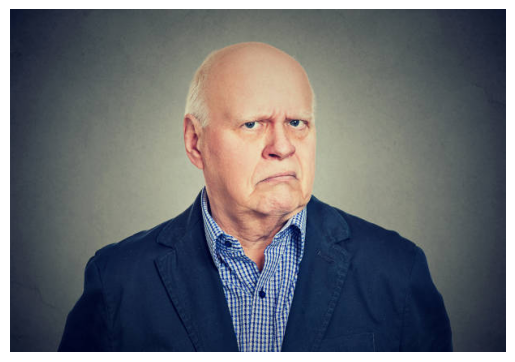

In [18]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='gender', ylabel='count'>

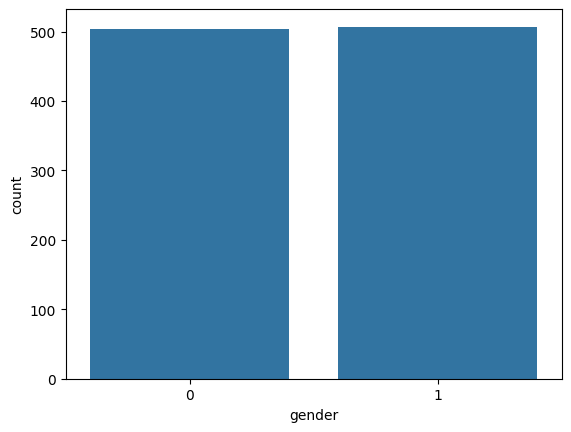

In [25]:
sns.countplot(x='gender', data=df)

<Axes: xlabel='glasses', ylabel='count'>

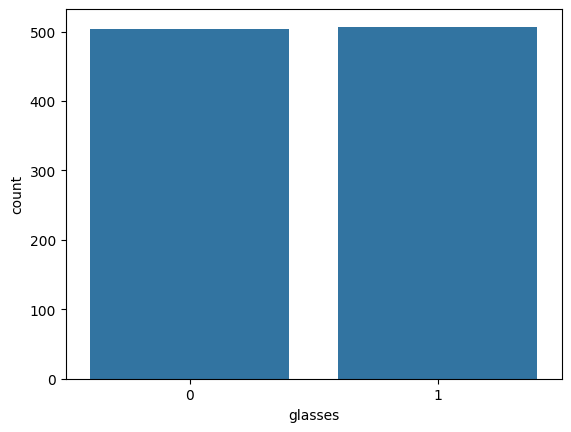

In [26]:
sns.countplot(x='glasses', data=df)

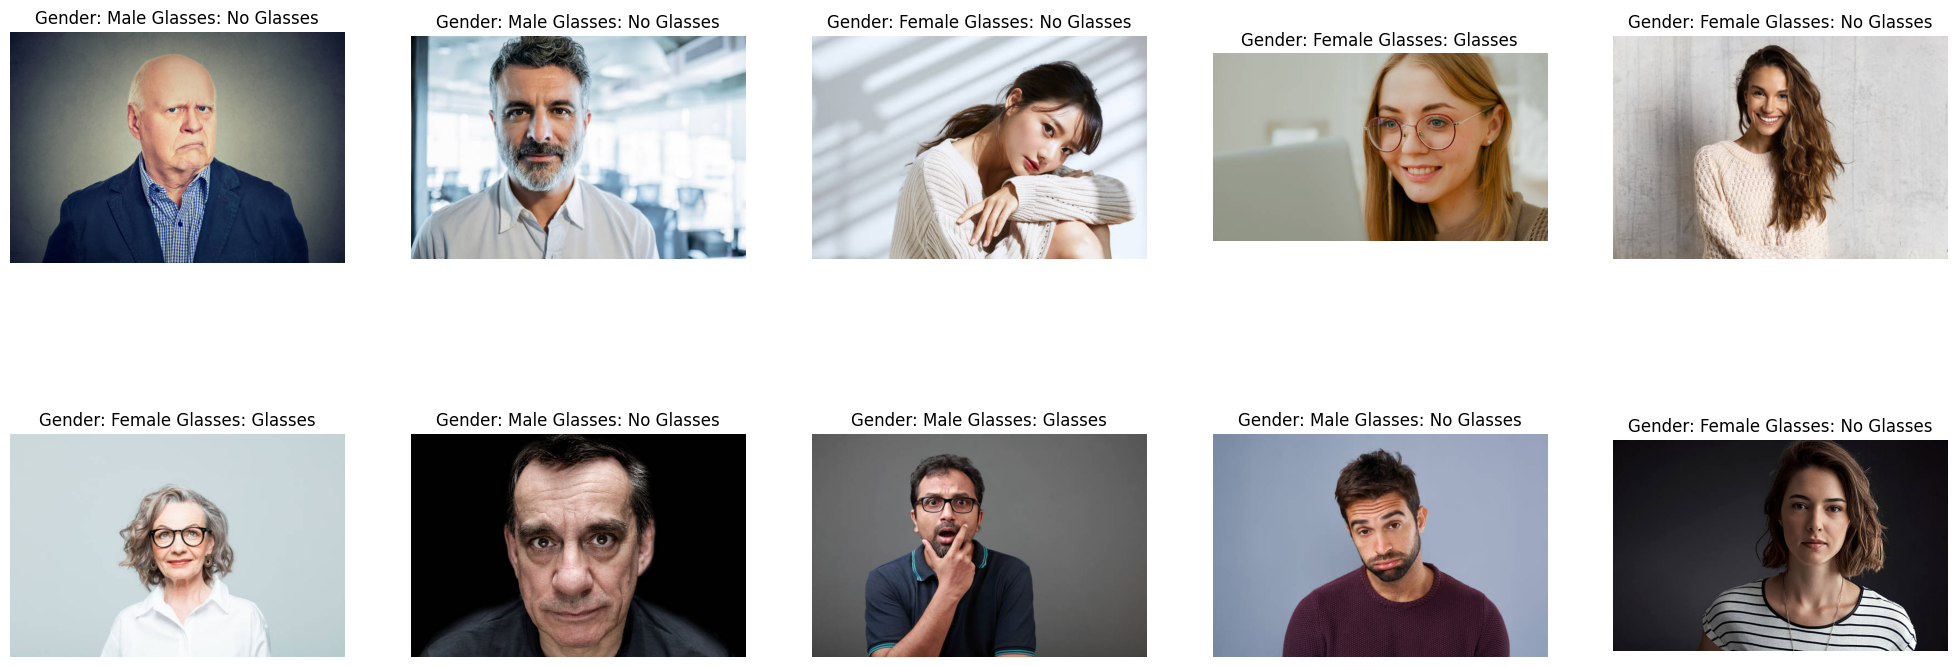

In [30]:
#to display grid of images
plt.figure(figsize=(25,25))
files = df.iloc[0:10]

for index, file, gender, glasses in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Gender: {gender_dict[gender]} Glasses: {glasses_dict[glasses]}")
    plt.axis('off')

## Feature Extraction



In [31]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(128, 128))
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features    

In [32]:
X = extract_features(df['image'])

  0%|          | 0/1010 [00:00<?, ?it/s]

In [33]:
X.shape

(1010, 128, 128, 1)

In [34]:
#normalization
X = X/255.0

In [35]:
y_gender = np.array(df['gender'])
y_glasses = np.array(df['glasses'])

In [36]:
input_shape = (128, 128, 1)

## Model Creation 

In [61]:
inputs = Input((input_shape))
#convolutional layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten() (maxp_4)

#fully connected layers
dense_1 = Dense(256, activation = 'relu')(flatten)
dropout_1 = Dropout(0.3)(dense_1)
output_1 = Dense(1, activation = 'sigmoid', name= 'gender_out')(dropout_1)

dense_2 = Dense(256, activation = 'relu')(flatten)
dropout_2 = Dropout(0.3)(dense_2)
output_2 = Dense(1, activation = 'sigmoid', name= 'glasses_out')(dropout_2)

model = Model(inputs=[inputs], outputs = [output_1, output_2])

model.compile(
    loss={'gender_out': 'binary_crossentropy', 'glasses_out': 'binary_crossentropy'},
    optimizer='adam',
    metrics={'gender_out': 'accuracy', 'glasses_out': 'accuracy'}
)


In [62]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 126, 126, 32)      │             320 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 63, 63, 32)        │               0 │ conv2d_12[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 61, 61, 64)        │          18,496 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_13              │ (None, 30, 30, 64)        │               0 │ conv2d_13[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 28, 28, 128)       │          73,856 │ max_pooling2d_13[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_14              │ (None, 14, 14, 128)       │               0 │ conv2d_14[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 12, 12, 256)       │         295,168 │ max_pooling2d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 6, 6, 256)         │               0 │ conv2d_15[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 9216)              │               0 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 256)               │       2,359,552 │ flatten_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 256)               │       2,359,552 │ flatten_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 256)               │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 256)               │               0 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_out (Dense)            │ (None, 1)                 │             257 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X) 

history = model.fit(
    x=X,
    y={'gender_out': y_gender, 'glasses_out': y_glasses},
    batch_size=16,
    epochs=7,
    validation_split=0.2
)

Epoch 1/7
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - gender_out_accuracy: 0.5363 - gender_out_loss: 0.6955 - glasses_out_accuracy: 0.4908 - glasses_out_loss: 0.7097 - loss: 1.4053 - val_gender_out_accuracy: 0.4307 - val_gender_out_loss: 0.6961 - val_glasses_out_accuracy: 0.4901 - val_glasses_out_loss: 0.6931 - val_loss: 1.3892
Epoch 2/7
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - gender_out_accuracy: 0.5279 - gender_out_loss: 0.6912 - glasses_out_accuracy: 0.5019 - glasses_out_loss: 0.6932 - loss: 1.3844 - val_gender_out_accuracy: 0.6089 - val_gender_out_loss: 0.6487 - val_glasses_out_accuracy: 0.5446 - val_glasses_out_loss: 0.6924 - val_loss: 1.3390
Epoch 3/7
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - gender_out_accuracy: 0.6597 - gender_out_loss: 0.6174 - glasses_out_accuracy: 0.5718 - glasses_out_loss: 0.6908 - loss: 1.3082 - val_gender_out_accuracy: 0.6238 - val_gender_out_loss: 0.5843 - val_glasses_out_accuracy: 0.5644 - val_glasses_out_loss: 0.6912 - val_loss: 1.2719
Epoch 4/7


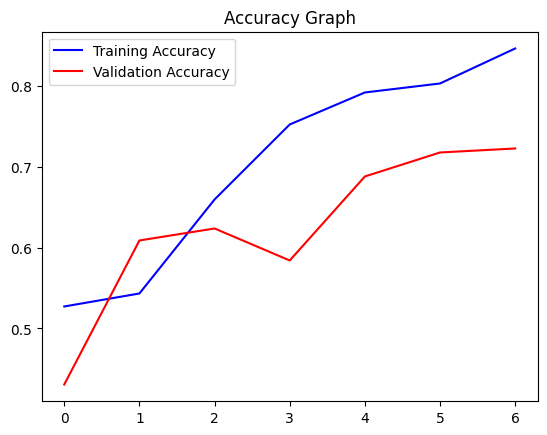

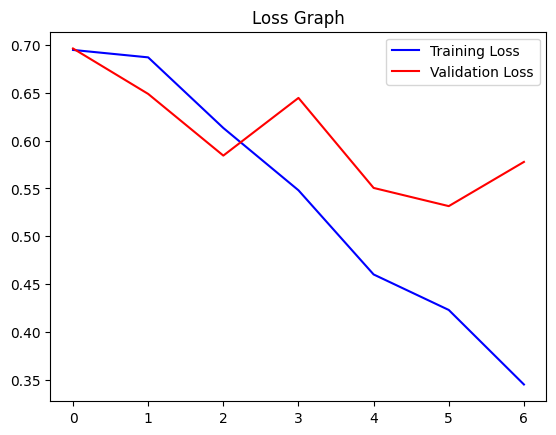

In [64]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


## Prediction with test data

Original Gender: Male Original Glasses: Glasses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predicted Gender: Male Predicted Glasses: Glasses


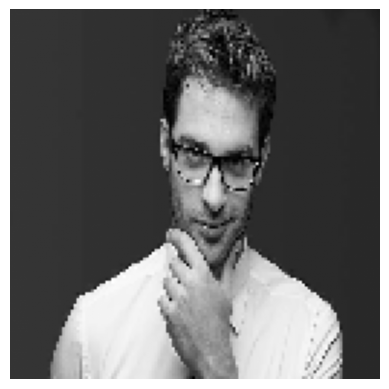

In [65]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Glasses:", glasses_dict[y_glasses[image_index]]) 

#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_glasses = glasses_dict[round(pred[0][0][0])]
print("Predicted Gender:", pred_gender, "Predicted Glasses:", pred_glasses)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');


Original Gender: Female Original Glasses: No Glasses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Gender: Female Predicted Glasses: No Glasses


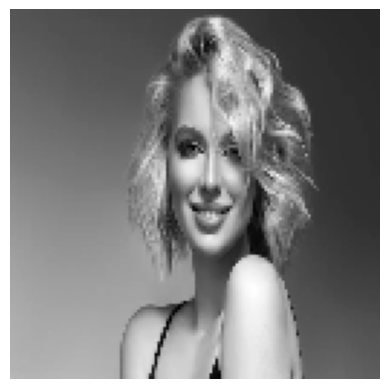

In [66]:
image_index = 110
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Glasses:", glasses_dict[y_glasses[image_index]]) 

#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_glasses = glasses_dict[round(pred[0][0][0])]
print("Predicted Gender:", pred_gender, "Predicted Glasses:", pred_glasses)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');


Original Gender: Female Original Glasses: Glasses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Gender: Female Predicted Glasses: No Glasses


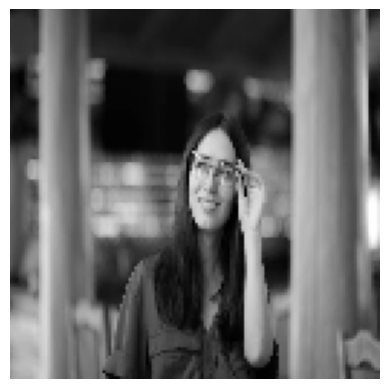

In [68]:
image_index = 160
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Glasses:", glasses_dict[y_glasses[image_index]]) 

#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_glasses = glasses_dict[round(pred[0][0][0])]
print("Predicted Gender:", pred_gender, "Predicted Glasses:", pred_glasses)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');


Original Gender: Female Original Glasses: No Glasses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Gender: Female Predicted Glasses: No Glasses


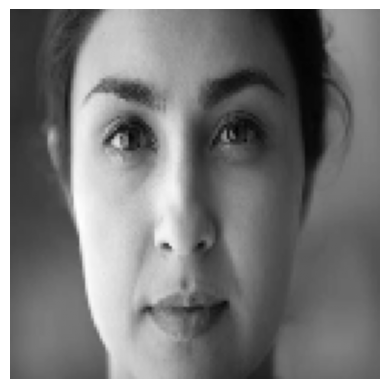

In [69]:
image_index = 199
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Glasses:", glasses_dict[y_glasses[image_index]]) 

#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_glasses = glasses_dict[round(pred[0][0][0])]
print("Predicted Gender:", pred_gender, "Predicted Glasses:", pred_glasses)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');


In [71]:
model.save('my_model.keras')


In [77]:
model.save_weights('face_features.weights.h5')